# Covariance for Angular Power Spectra with *Heracles*

This notebook demonstrates how *Heracles* computes an estimate of the covariance of the two-point statistics from a 3×2pt catalogue using the DICES method. This tutorial is heavily based on the summary statisitcs tutorial so we will reproduce the results found in said tutorial without going into the details of the analysis. We will then show how to compute the covariance of the angular power spectra using *Heracles*.

<div class="alert alert-info">

**Important note**

This notebook is only meant to give you an idea of **how *Heracles* works**.

It does **not** show everything that *Heracles* can do.

**This is a toy, treat it is such!**

</div>

## Setup

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import heracles
import heracles.healpy
from heracles.notebook import Progress

# Covariance code
import heracles.dices as dices

import helpers

with Progress("example data") as progress:
    helpers.get_example_data(progress)

VBox()

## Basic parameters

This is the resolution parameter for measuring spectra from *HEALPix* maps.  Here, we use `nside = 128` since that is the resolution at which the example data has been created. A value `lmax` of approximate 1.5x `nside` is fairly safe in terms of errors introduced by *HEALPix*. For the purpose of this tutorial we will only use 3 tomographic bins.

In [2]:
nside = 128
lmax = 150
nbins = 3

## Prepare maps

For this tutorial we will use the same data as in the summary statistics tutorial. Note that the maps generated in the summary statistics tutorial might have a different resolution. Therefore we will have to up/down-scale them accordingly. Doing so, unfortunately destroys the metadata of the maps. Therefore we will have to manually re-enter the metadata.

In [3]:
data_maps = heracles.read_maps("example-data_maps.fits")

In [4]:
data_maps = heracles.read_maps("example-data_maps.fits")
for key in list(data_maps.keys()):
    f, i = key
    if i <= nbins:
        _map = data_maps[key]
        meta = _map.dtype.metadata
        new_map = hp.ud_grade(_map, nside)
        heracles.update_metadata(
            new_map,
            nside=nside,
            lmax=lmax,
            bias=meta["bias"],
            fsky=meta["fsky"],
            spin=meta["spin"],
        )
        data_maps[key] = new_map
    else:
        data_maps.pop(key)

# load the FITS mask
vis_map = hp.read_map("vmap.fits.gz")
vis_map[vis_map == hp.UNSEEN] = 0.0
vis_map = hp.ud_grade(vis_map, nside)
heracles.update_metadata(
            vis_map,
            nside=nside,
            lmax=lmax,
            bias=0.0,
            fsky=meta["fsky"],
            spin=0,
        )
vis_maps = {}
for key in list(data_maps.keys()):
    f, i = key
    if f == "POS":
        f = "VIS"
    if f == "SHE":
        f = "WHT"
    key = (f, i)
    vis_maps[key] = vis_map

## Jackknife Regions

The fundamental idea behind Jackknife approaches is to generate an ensemble of angular power spectra by leaving out one of the regions at a time. The covariance of the angular power spectra can then be estimated from the variance of the ensemble. Therefore, the first step is to divide the mask of the survey into regions. In order to do so, in this tutorial we will make use of the SkySegmentor library. However, any library that segments the sky into regions can be used.

In [5]:
import skysegmentor

In [6]:
jk_maps = {}
Njk = 30
jk_map = skysegmentor.segmentmapN(vis_map, Njk)
for key in list(vis_maps.keys()):
    jk_maps[key] = jk_map

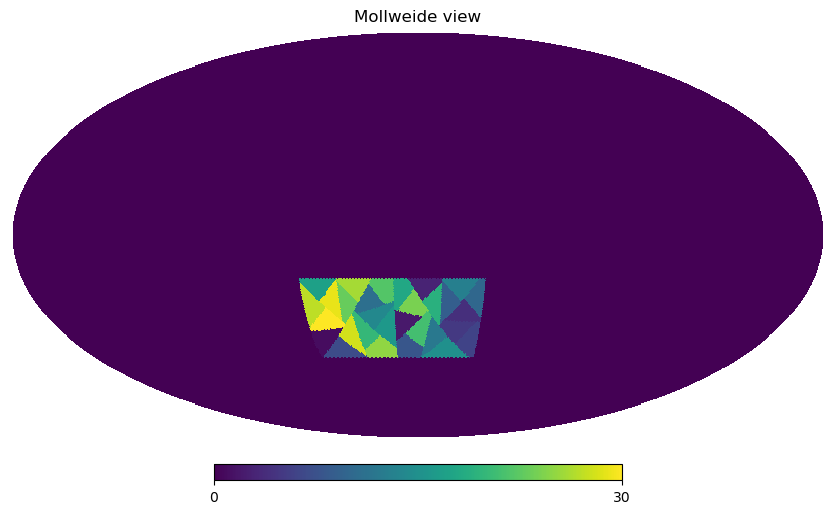

In [7]:
hp.mollview(jk_maps[("VIS", 1)])

## Two-point statistics

Since the computation of the two-point statistics was already covered in the summary statistics tutorial, we will not go into the details of the analysis. We will simply load the results from the summary statistics tutorial and use them to compute the covariance of the angular power spectra.

In [8]:
# TO DO: just 
cls0 = dices.get_cls(data_maps, jk_maps)
mls0 = dices.get_cls(vis_maps, jk_maps)

## Theory

Similarly, in this tutorial we will limit ourselves to loading the thoeory power spectra from the summary statistics tutorial.

In [9]:
theory = heracles.read("example-theory.fits")
for key in list(theory.keys()):
    f1, f2, i1, i2 = key
    if (i2 <= nbins) and (i1 <= nbins):
        if f1 == f2 == "POS":
            theory[key] = theory[key][: lmax + 1]
        else:
            theory[key] = theory[key][:, : lmax + 1]
    else:
        theory.pop(key)

## Ensemble Computation

Compute the ensemble of angular power spectrum effectively boils down to repeating the process presented in the two-point statistics section removing one of the jackknife regions at a time. However, a couple of extra considerations have to be made.
- When computing the angular power spectra from catalogues, removing one of the jackknife regions changes the sample variance of the angular power spectra by a factor of 
$$
b_{jk} = b (1-\frac{1}{N})
$$
- Moreover, removing of the jackknife regions also changes the footprint of the survey which can introduce additional mixing betweeen E- and B-modes. Heracles is equiped with a mask correction routine that corrects for this effect by transforming the angular power spectra to real space, dividing the correlation function of the ratio of new footprint to the old footprint and transforming back to harmonic space. 
$$
 C_\ell \rightarrow \xi(\theta) \\
 M_\ell \rightarrow \xi_m(\theta) \\
 M^{\rm jk}(\theta) \rightarrow \xi^{\rm jk}_m(\theta) \\
$$
$$
\bar{\xi}(\theta) = \xi(\theta) \frac{\xi_m(\theta)}{\xi^{\rm jk}_m(\theta)} \\
$$
$$
\bar{\xi}(\theta) \rightarrow \bar{C}_\ell
$$

In [10]:
cls1 = {}
for jk in range(1, Njk + 1):
    _cls = dices.get_cls(data_maps, jk_maps, jk=jk)
    _cls_mm = dices.get_cls(vis_maps, jk_maps, jk=jk)
    # Mask correction
    _cls = dices.correct_mask(_cls, _cls_mm, mls0)
    # Bias correction
    _cls = dices.correct_bias(_cls, jk_maps, jk=jk)
    cls1[jk] = _cls

To add numerically stability to our computations, we will also bin the ensemble of angular power spectra.

In [11]:
nlbins = 10
ell = np.arange(lmax + 1)
ledges = np.logspace(np.log10(10), np.log10(lmax), nlbins + 1)
lgrid = (ledges[1:] + ledges[:-1]) / 2

In [12]:
cqs0 = heracles.binned(cls0, ledges)
cqs1 = heracles.binned(cls1, ledges)

## Delete1 Covariance

The 'delete1' covariance is computed from the ensemble of delete1 angular power spectra. The computation relies on the $W^1$-matrices defined as:
$$
W^1_{ij} = \left( C_{\ell \, i} - \bar{C}_{\ell \, i} \right) \left( C_{\ell \, j} - \bar{C}_{\ell \, j} \right) \, ,
$$
where $i$ and $j$ are the indices of the $C_{\ell}$'s in the ensemble. The covariance matrix is then computed as:
$$
\mathbb{C}^1 = \frac{N}{N-1} \bar{W^1} \, .
$$


In [13]:
delete1_cov = dices.get_delete1_cov(cqs0, cqs1)

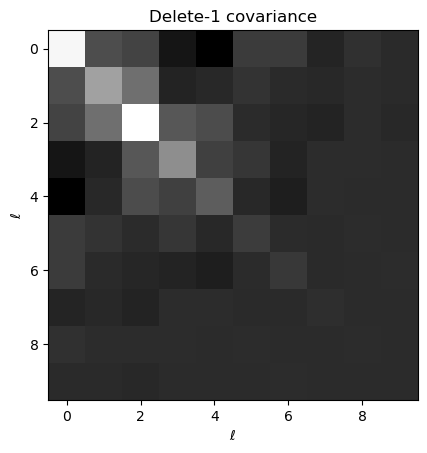

In [14]:
plt.imshow(delete1_cov[("POS", "POS", "POS", "POS", 1, 1, 1, 1)], cmap="grey")
plt.title("Delete-1 covariance")
plt.ylabel(r"$\ell$")
plt.xlabel(r"$\ell$")
plt.show()

## Shrinkage

To improve the stability of the off-diagonal elements of the covariance matrix, we can apply a linear shrinkage to a Gaussian target. Since we don't have access to theory $C_{\ell}'s$, the Gaussian target is computed from the mean $C_{\ell}$'s in the ensemble using the known formula:
$$
\mathbb{G}^{abcd} = \frac{(C_{\ell}^{ab}+b^{ab}) (C_{\ell}^{cd}+b^{cd}) + (C_{\ell}^{ac}+b^{ac}) (C_{\ell}^{bd}+b^{bd})}{2 \ell + 1} \, ,
$$
withour taking into account the partial sky. The shrinkage factor is then computed by comparing the variance of the target to the variance of the $W^1$-matrices. To ensure that the diagonal elements of $\mathbb{C}_1$ remain unchanged, we modify $\mathbb{G}$ as:
$$
\tilde{\mathbb{G}}_{ii} = \mathbb{C}_{1 \, ii} \\
\tilde{\mathbb{G}}_{ij} = \mathbb{G}_{ij} \sqrt{\mathbb{C}_{1 \, ii} \mathbb{C}_{1 \, ij}}\, .
$$

The shrunk covariance matrix is then given by:
$$
\mathbb{C}^{\rm shrunk \, 1} = \lambda \tilde{\mathbb{G}} + (1-\lambda) \mathbb{C}^1 \, .
$$

In [15]:
W = dices.get_W(cqs1)
target_cov = dices.get_gaussian_target(cqs1)
shrinkage = dices.get_shrinkage(cqs0, target_cov, W)
shrunk_cov1 = dices.shrink_cov(
    cqs0,
    delete1_cov, 
    target_cov,
    shrinkage)

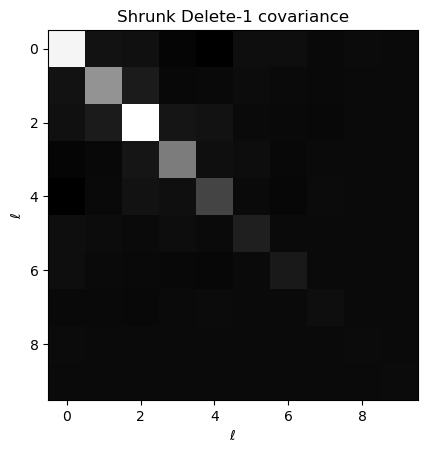

In [16]:
plt.imshow(shrunk_cov1[("POS", "POS", "POS", "POS", 1, 1, 1, 1)], cmap="grey")
plt.title("Shrunk Delete-1 covariance")
plt.ylabel(r"$\ell$")
plt.xlabel(r"$\ell$")
plt.show()

## Delete2 Covariance

The computation of the DICES covariance also requires the computation of the 'delete2' covariance. This is done by computing the ensemble of delete2 angular power spectra and then computing the W-matrices as:
$$
W^2_{ij} = N  C_{\ell}^0 - (N-1) \left( C_{\ell \, i}^1 + C_{\ell \, j}^1 \right) + (N-2) C_{\ell \, ij}^2 \, .
$$
These new $W^2$-matrices define a new covariance which we will call $Q$. However, $Q$ is not the delete2 covariance. To compute the delete2 covariance, we have to substract $Q$ from $\mathbb{C}^1$ such that:
$$
\mathbb{C}^2 = \mathbb{C}^1 - Q \, .
$$

In [17]:
cls2 = {}
for jk in range(1, Njk + 1):
    for jk2 in range(jk + 1, Njk + 1):
        _cls = dices.get_cls(data_maps, jk_maps, jk=jk, jk2=jk2,)
        _cls_mm = dices.get_cls(vis_maps, jk_maps, jk=jk, jk2=jk2)
        # Mask correction
        _cls = dices.correct_mask(_cls, _cls_mm, mls0)
        # Bias correction
        _cls = dices.correct_bias(_cls, jk_maps, jk=jk, jk2=jk2)
        cls2[(jk, jk2)] = _cls

In [18]:
cqs2 = heracles.binned(cls2, ledges)

In [19]:
delete2_cov = dices.get_delete2_cov(
    delete1_cov,
    cqs0,
    cqs1,
    cqs2,
)

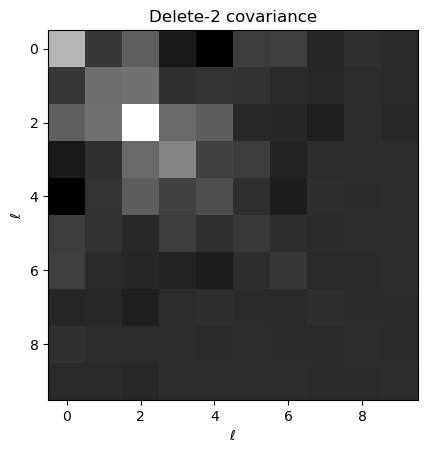

In [20]:
plt.imshow(delete2_cov[("POS", "POS", "POS", "POS", 1, 1, 1, 1)], cmap="grey")
plt.title("Delete-2 covariance")
plt.ylabel(r"$\ell$")
plt.xlabel(r"$\ell$")
plt.show()

## DICES Covariance

Finally the DICES covariance is computed as by multiplying the correlation matricies of $\mathbb{C}^{\rm shrunk \, 1}$ and $\mathbb{C}^2$:
$$
\mathbb{D} = \left(\frac{\mathbb{C}^{\rm shrunk \, 1}}{\sqrt{\mathbb{C}^{\rm shrunk \, 1}_{ii} \mathbb{C}^{\rm shrunk\, 1}_{ii} }}\right) \left(\frac{\mathbb{C}^2}{\sqrt{\mathbb{C}^2_{ii} \mathbb{C}^2_{ii}}} \right)\, .
$$

In [21]:
dices_cov = dices.get_dices_cov(cqs0, shrunk_cov1, delete2_cov)

In [22]:
_delete1_cov = dices.Components2Fields(cqs0, delete1_cov)
_dices_cov = dices.Components2Fields(cqs0, dices_cov)

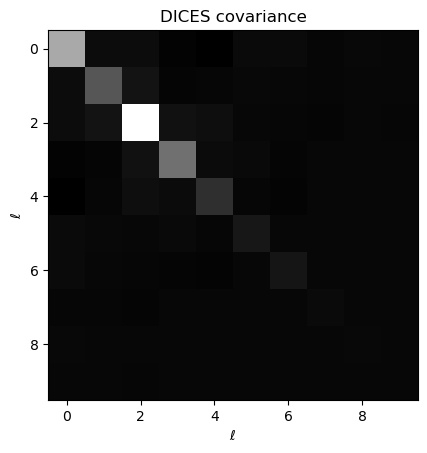

In [23]:
plt.imshow(dices_cov[("POS", "POS", "POS", "POS", 1, 1, 1, 1)], cmap="grey")
plt.title("DICES covariance")
plt.ylabel(r"$\ell$")
plt.xlabel(r"$\ell$")
plt.show()

## Results

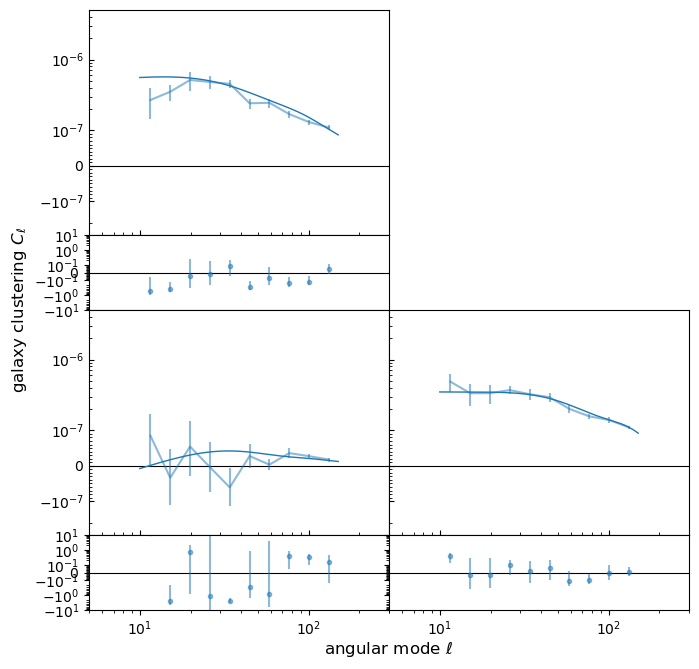

In [24]:
fig, ax = plt.subplots(
    2 * (nbins - 1),
    nbins - 1,
    figsize=(6, 6),
    gridspec_kw={"height_ratios": [3, 1, 3, 1]},
)


for i in range(1, nbins):
    for j in range(1, i):
        ax[j - 1, i - 1].axis("off")
        ax[j, i - 1].axis("off")
    for j in range(i, nbins):
        key = ("POS", "POS", i, j)
        cov_key = ("POS", "POS", "POS", "POS", i, j, i, j)
        c = _dices_cov[cov_key][0, 0, :, :]
        err = np.sqrt(np.diag(c))
        ax[2 * (j - 1), i - 1].errorbar(
            lgrid, cqs0[key], yerr=err, c="C0", lw=1.5, zorder=3.0, alpha=0.5
        )
        ax[2 * (j - 1), i - 1].plot(
            ell[10:], theory[key][10:], c="C0", lw=1.0, zorder=4.0
        )
        ax[2 * (j - 1), i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[2 * (j - 1) + 1, i - 1].errorbar(
            lgrid,
            (cqs0[key][:] - heracles.binned(theory[key][1:], ledges))
            / heracles.binned(theory[key][1:], ledges),
            yerr=np.abs(err / cqs0[key][:]),
            fmt=".",
            c="C0",
            lw=1.5,
            zorder=1.0,
            alpha=0.5,
        )
        ax[2 * (j - 1) + 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)

        ax[2 * (j - 1), i - 1].tick_params(axis="both", which="both", direction="in")
        ax[2 * (j - 1), i - 1].set_yscale(
            "symlog", linthresh=1e-7, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
        )
        ax[2 * (j - 1), i - 1].set_ylim(-3e-7, 5e-6)
        ax[2 * (j - 1) + 1, i - 1].set_yscale(
            "symlog", linthresh=0.1, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
        )
        ax[2 * (j - 1) + 1, i - 1].set_ylim(-10, 10)

        ax[2 * (j - 1), i - 1].set_xscale("log")
        ax[2 * (j - 1), i - 1].set_xlim(5, lmax * 2)
        ax[2 * (j - 1) + 1, i - 1].set_xscale("log")
        ax[2 * (j - 1) + 1, i - 1].set_xlim(5, lmax * 2)
        if i > 1:
            ax[2 * (j - 1), i - 1].set_yticklabels([])
            ax[2 * (j - 1) + 1, i - 1].set_yticklabels([])


fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel("galaxy clustering $C_\\ell$", x=-0.1, ha="right")

plt.show()

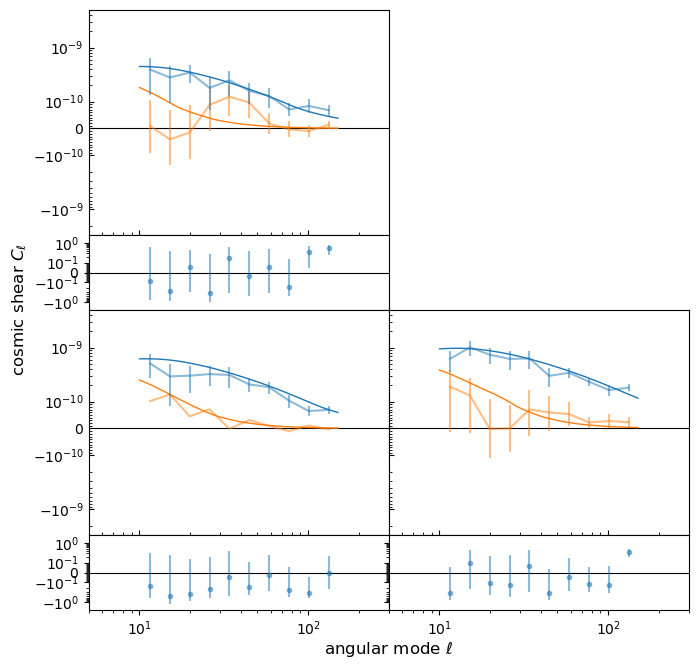

In [25]:
fig, ax = plt.subplots(
    2 * (nbins - 1),
    nbins - 1,
    figsize=(6, 6),
    gridspec_kw={"height_ratios": [3, 1, 3, 1]},
)

for i in range(1, nbins):
    for j in range(1, i):
        ax[j - 1, i - 1].axis("off")
        ax[j, i - 1].axis("off")
    for j in range(i, nbins):
        key = ("SHE", "SHE", i, j)
        cov_key = ("SHE", "SHE", "SHE", "SHE", i, j, i, j)
        e_c = _delete1_cov[cov_key][0, 0]
        e_err = np.sqrt(np.diag(e_c))
        b_c = _delete1_cov[cov_key][1, 1]
        b_err = np.sqrt(np.diag(b_c))
        ax[2 * (j - 1), i - 1].errorbar(
            lgrid,
            cqs0[key][0, :],
            yerr=e_err,
            c="C0",
            lw=1.5,
            zorder=3.0,
            alpha=0.5,
        )
        ax[2 * (j - 1), i - 1].plot(
            ell[10:], theory[key][0, 10:], c="C0", lw=1.0, zorder=4.0
        )
        ax[2 * (j - 1) + 1, i - 1].errorbar(
            lgrid,
            (cqs0[key][0, :] - heracles.binned(theory[key][0, 2:], ledges))
            / heracles.binned(theory[key][0, 2:], ledges),
            yerr=np.abs(e_err / cqs0[key][0, :]),
            fmt=".",
            c="C0",
            lw=1.5,
            zorder=1.0,
            alpha=0.5,
        )
        ax[2 * (j - 1), i - 1].errorbar(
            lgrid,
            cqs0[key][1, :],
            yerr=b_err,
            c="C1",
            lw=1.5,
            zorder=1.0,
            alpha=0.5,
        )
        ax[2 * (j - 1), i - 1].plot(
            ell[10:],
            theory[key][1, 10:],
            c="C1",
            lw=1.0,
            zorder=2.0,
        )
        ax[2 * (j - 1), i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[2 * (j - 1) + 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[2 * (j - 1), i - 1].tick_params(axis="both", which="both", direction="in")
        ax[2 * (j - 1), i - 1].set_yscale(
            "symlog", linthresh=1e-10, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
        )
        ax[2 * (j - 1), i - 1].set_ylim(-3e-9, 5e-9)
        ax[2 * (j - 1) + 1, i - 1].set_yscale(
            "symlog", linthresh=0.1, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
        )
        ax[2 * (j - 1) + 1, i - 1].set_ylim(-2.5, 2.5)

        ax[2 * (j - 1), i - 1].set_xscale("log")
        ax[2 * (j - 1), i - 1].set_xlim(5, lmax * 2)
        ax[2 * (j - 1) + 1, i - 1].set_xscale("log")
        ax[2 * (j - 1) + 1, i - 1].set_xlim(5, lmax * 2)
        if i > 1:
            ax[2 * (j - 1), i - 1].set_yticklabels([])
            ax[2 * (j - 1) + 1, i - 1].set_yticklabels([])
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(
    numticks=99, subs=np.arange(0.1, 1.0, 0.1)
)
# ax[0, 0].set_yscale(
#    "symlog", linthresh=1e-10, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
# )
# ax[0, 0].set_ylim(-3e-7, 5e-7)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel("cosmic shear $C_\\ell$", x=-0.1, ha="right")

plt.show()

/tmp/ipykernel_86984/1414403870.py:15: RuntimeWarning: invalid value encountered in sqrt
  b_err = np.sqrt(np.diag(b_c))


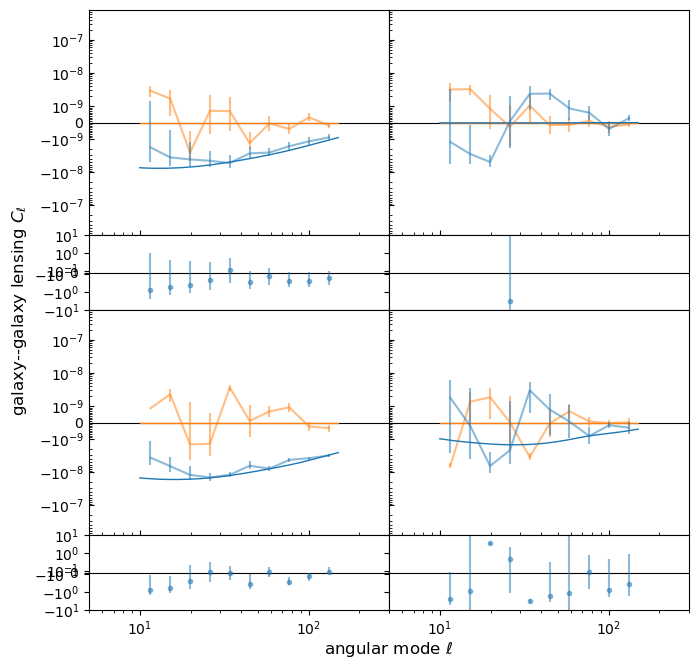

In [26]:
fig, ax = plt.subplots(
    2 * (nbins - 1),
    (nbins - 1),
    figsize=(6, 6),
    gridspec_kw={"height_ratios": [3, 1, 3, 1]},
)

for i in range(1, nbins):
    for j in range(1, nbins):
        key = ("POS", "SHE", i, j)
        cov_key = ("POS", "SHE", "POS", "SHE", i, j, i, j)
        e_c = _dices_cov[cov_key][0, 0]
        e_err = np.sqrt(np.diag(e_c))
        b_c = _dices_cov[cov_key][0, 1]
        b_err = np.sqrt(np.diag(b_c))
        ax[2 * (j - 1), i - 1].errorbar(
            lgrid,
            cqs0[key][0, :],
            yerr=e_err,
            c="C0",
            lw=1.5,
            zorder=3.0,
            alpha=0.5,
        )
        ax[2 * (j - 1), i - 1].plot(
            ell[10:], theory[key][0, 10:], c="C0", lw=1.0, zorder=4.0
        )
        ax[2 * (j - 1) + 1, i - 1].errorbar(
            lgrid,
            (cqs0[key][0, :] - heracles.binned(theory[key][0, 2:], ledges))
            / heracles.binned(theory[key][0, 2:], ledges),
            yerr=np.abs(e_err / cqs0[key][0, :]),
            fmt=".",
            c="C0",
            lw=1.5,
            zorder=1.0,
            alpha=0.5,
        )
        ax[2 * (j - 1), i - 1].errorbar(
            lgrid,
            cqs0[key][1, :],
            yerr=b_err,
            c="C1",
            lw=1.5,
            zorder=1.0,
            alpha=0.5,
        )
        ax[2 * (j - 1), i - 1].plot(
            ell[10:], theory[key][1, 10:], c="C1", lw=1.0, zorder=2.0
        )
        ax[2 * (j - 1), i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[2 * (j - 1) + 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[2 * (j - 1), i - 1].tick_params(axis="both", which="both", direction="in")

        ax[2 * (j - 1), i - 1].set_yscale(
            "symlog", linthresh=1e-9, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
        )
        ax[2 * (j - 1), i - 1].set_ylim(-8e-7, 8e-7)
        ax[2 * (j - 1) + 1, i - 1].set_yscale(
            "symlog",
            linthresh=0.1,
            linscale=0.1,
        )
        ax[2 * (j - 1) + 1, i - 1].set_ylim(-10, 10)

        ax[2 * (j - 1), i - 1].set_xscale("log")
        ax[2 * (j - 1), i - 1].set_xlim(5, lmax * 2)
        ax[2 * (j - 1) + 1, i - 1].set_xscale("log")
        ax[2 * (j - 1) + 1, i - 1].set_xlim(5, lmax * 2)
        if i > 1:
            ax[2 * (j - 1), i - 1].set_yticklabels([])
            ax[2 * (j - 1) + 1, i - 1].set_yticklabels([])

# ax[0, 0].set_xscale("log")
# ax[0, 0].set_xlim(1 / 2, lmax * 2)
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(
    numticks=99, subs=np.arange(0.1, 1.0, 0.1)
)
# ax[0, 0].set_yscale(
#    "symlog", linthresh=1e-9, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
# )
# ax[0, 0].set_ylim(-8e-7, 4e-7)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel("galaxy--galaxy lensing $C_\\ell$", x=-0.1, ha="right")

plt.show()